In [1]:
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import torch

from torchvision.io import read_image, write_png
from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDataset, DAGMDatasetDev
from src.deep_ad.data.dagm_utils import dagm_get_patches_dir, dagm_get_image_path, dagm_get_class, dagm_get_label_name
from src.deep_ad.eval import pad_image
from src.deep_ad.image import intersection_over_union, show_image_with_bboxes, plot_images, TBBox
from src.deep_ad.transforms import create_to_image_transform, normalize_to_mean_std, create_test_transform

In [2]:
# Load the configuration
config = Config(root_dir="..", config_path="../default_config.yml")

### Generate patches


The reconstruction CNN uses only defect-free patches so I need to prepare a dataset containing them. I will take a
constant number of patches from each image from the raw dataset. According to the original paper, they cropped patches
larger than 128x128 pixels in order to avoid border effects after applying random transforms. However, they didn't
specify the size of the patches.

For better training, I thought that patches taken from the same image need to cover as much details as possible, so
overlappings should be minimized. Thus, the intersection over union between each pair of patches must not exceed a
certain threshold.

Patches obtained will be saved in a folder structure identical to that of the raw DAGM dataset. However, each patch's
name will contain the name, id (integer from `0` to `ppi - 1`) and the `x` and `y` coordinates of the
top-left corner. This new dataset will be saved in a directory uniquely identified by its configuration parameters: ppi
(patches per image) and patch size in pixels.


Existing patches should be deleted, as new ones might not overwrite them.


In [104]:
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True, name=config.patches_dataset_name)
# patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True)
if not os.path.exists(patches_dir):
    print(f'Directory "{patches_dir}" does not exist. Exiting.')
else:
    number_of_files = len(glob.glob(os.path.join(patches_dir, "Class*", "Train", "*.png")))
    prompt = f'Are you sure you want to delete {number_of_files} files inside "{patches_dir}"? (y/n) '
    response = input(prompt).strip().lower()
    if response != "y":
        print("Exiting.")
    else:
        print(f'Deleting {number_of_files} files inside "{patches_dir}"...')
        shutil.rmtree(patches_dir)
        print("Done.")

Deleting 28016 files inside "..\data\processed\DAGM\4ppi_176px_pad_v2"...
Done.


Load only defect-free images and crop a fixed number of patches from each one of them.


In [3]:
dagm_ds = DAGMDatasetDev(config.DAGM_raw_dir, type="Defect-free")

In [106]:
%matplotlib inline
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True, name=config.patches_dataset_name)
initial_number_of_patches = len(glob.glob(os.path.join(patches_dir, 'Class*', 'Train', '*.png')))
print("Config:")
print(f"\tppi: {config.ppi}")
print(f"\traw_patch_size: {config.raw_patch_size}")
print(f"\tpatches_iou_threshold: {config.patches_iou_threshold}")
print(f"\tpatches_pad: {config.patches_pad}")
print(f"\tpatches_dataset_name: {config.patches_dataset_name}")
print(f'Will save patches to "{patches_dir}".')

# Keep track of number of retries for each image
retries: list[int] = []

# Create directories for each class
for cls in dagm_ds.all_classes:
    cls_patches_dir = os.path.join(patches_dir, f"Class{cls}", "Train")
    if not os.path.exists(cls_patches_dir):
        os.makedirs(cls_patches_dir)

# Generate patches
for image_idx in tqdm(range(len(dagm_ds)), desc="Images processed", unit="image"):
    image, label, cls, name = dagm_ds[image_idx]
    cls_patches_dir = os.path.join(patches_dir, f"Class{cls}", "Train")
    patch_bboxes: list[TBBox] = []
    padded_image, _, margin, _ = pad_image(config, image.unsqueeze(0), patch_size=config.raw_patch_size)

    for _ in range(config.ppi):
        # Keep generating random coordinates while iou is greater than threshold
        n_retries = 0
        while True:
            top_left_x = np.random.randint(margin, padded_image.shape[1] - config.raw_patch_size + 1)
            top_left_y = np.random.randint(margin, padded_image.shape[0] - config.raw_patch_size + 1)
            bbox: TBBox = (
                top_left_x,
                top_left_y,
                top_left_x + config.raw_patch_size - 1,
                top_left_y + config.raw_patch_size - 1,
            )
            if np.all([intersection_over_union(bbox, bbox_) <= config.patches_iou_threshold for bbox_ in patch_bboxes]):
                patch_bboxes.append(bbox)
                retries.append(n_retries)
                break
            n_retries += 1

    # Save the patches
    for patch_idx, bbox in enumerate(patch_bboxes):
        patch = padded_image[bbox[1] : bbox[3] + 1, bbox[0] : bbox[2] + 1].unsqueeze(0)
        patch_name = f"{name}_{patch_idx}_{bbox[0]}_{bbox[1]}.png"
        patch_path = os.path.join(cls_patches_dir, patch_name)
        write_png(patch, patch_path)

print(f"Generated a total of {len(glob.glob(os.path.join(patches_dir, 'Class*', 'Train', '*.png'))) - initial_number_of_patches} patches.")

Config:
	ppi: 4
	raw_patch_size: 176
	patches_iou_threshold: 0.05
	patches_pad: True
	patches_dataset_name: v2
Will save patches to "..\data\processed\DAGM\4ppi_176px_pad_v2".


Images processed: 100%|██████████| 7004/7004 [01:19<00:00, 88.48image/s]


Generated a total of 28016 patches.


In [107]:
print(padded_image.shape)

torch.Size([680, 680])


Here is a report regarding the number of retries per patch.


Total number of retries: 21966
Average number of retries: 0.784
Max number of retries: 31


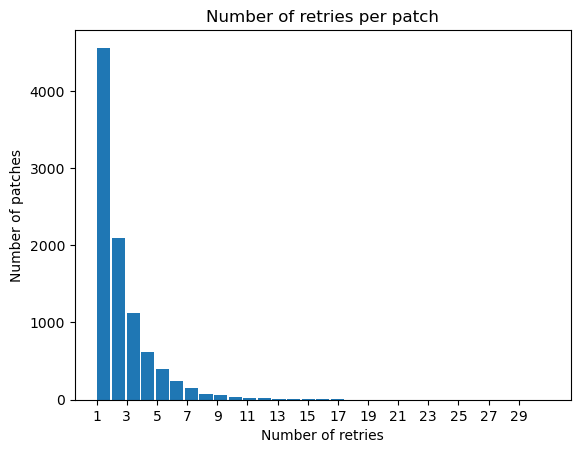

In [108]:
%matplotlib inline

retries = np.array(retries)
print(f"Total number of retries: {np.sum(retries)}")
print(f"Average number of retries: {np.mean(retries):.3f}")
print(f"Max number of retries: {np.max(retries)}")

# Plot histogram of number of retries
plt.hist(retries[retries > 0], bins=np.max(retries), rwidth=0.9)
plt.xticks(range(1, np.max(retries), 2))
plt.title("Number of retries per patch")
plt.xlabel("Number of retries")
plt.ylabel("Number of patches")
plt.show()

### Data about patches

Display an image and its bounding boxes.


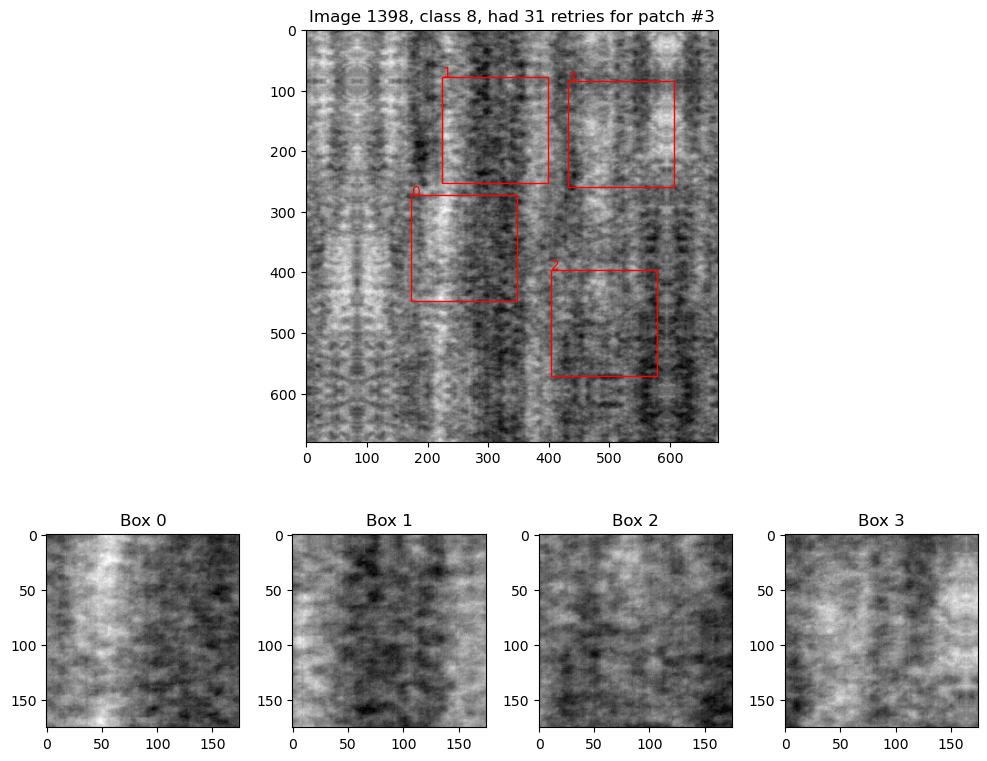

In [109]:
# Choose the image with the most retries
arg_max_retries = np.argmax(retries)
image, label, cls, name = dagm_ds[arg_max_retries // config.ppi]

image_cls = cls
image_name = name
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True)
bboxes: list[TBBox] = []
for i in range(config.ppi):
    patch_path = os.path.join(patches_dir, f"Class{image_cls}", "Train", f"{image_name}_{i}_*.png")
    patch_path = glob.glob(patch_path)[0]
    tl_x = int(patch_path.split("_")[-2])
    tl_y = int(patch_path.split("_")[-1].split(".")[0])
    bboxes.append((tl_x, tl_y, tl_x + config.raw_patch_size - 1, tl_y + config.raw_patch_size - 1))

image = read_image(os.path.join(config.DAGM_raw_dir, f"Class{image_cls}", "Train", f"{image_name}.png"))
padded_image, _, _, _ = pad_image(config, image.unsqueeze(0), patch_size=config.raw_patch_size)
show_image_with_bboxes(
    padded_image.squeeze().numpy(),
    bboxes,
    title=f"Image {image_name}, class {cls}, had {retries[arg_max_retries]} retries for patch #{arg_max_retries % config.ppi}",
)

Check the distribution of patches coordinates

..\data\processed\DAGM\4ppi_176px_pad_v2
Min pad: 76, margin: 8, pad size: 84, heatmap.shape: torch.Size([680, 680])
minx=8, maxx=504, miny=8, maxy=504


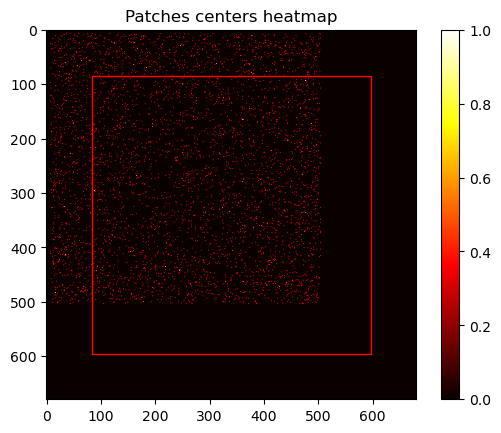

In [110]:
%matplotlib inline
import matplotlib.patches as mpl_patches

patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True, name=config.patches_dataset_name)
print(patches_dir)
patch_coords = []
for image_cls in range(1, 11):
    patches_dir_cls = os.path.join(patches_dir, f"Class{image_cls}", "Train")
    patches = glob.glob(os.path.join(patches_dir_cls, "*.png"))
    patch_coords.append([tuple(map(int, os.path.splitext(patch_path)[0].split("_")[-2:])) for patch_path in patches])

heatmap, min_pad, margin, pad_size = pad_image(config, torch.zeros((1, 512, 512)), patch_size=config.raw_patch_size)
print(f"Min pad: {min_pad}, margin: {margin}, pad size: {pad_size}, heatmap.shape: {heatmap.shape}")
# for coords in patch_coords:
coords = patch_coords[10 - 1]
minx, maxx, miny, maxy = 99999, -1, 99999, -1
for coord in coords:
    x, y = coord[1], coord[0]
    minx, maxx, miny, maxy = min(minx, x), max(maxx, x), min(miny, y), max(maxy, y)
    heatmap[x, y] += 1
print(f"minx={minx}, maxx={maxx}, miny={miny}, maxy={maxy}")

fig, ax = plt.subplots()
plt.imshow(heatmap, cmap="hot", vmin=0, vmax=heatmap.max() // 2)
hsize = heatmap.shape[-1]
rect = mpl_patches.Rectangle(((hsize - 512) // 2, (hsize - 512) // 2), 512, 512, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.title("Patches centers heatmap")
plt.colorbar()
plt.show()

### Mean & STD


In [6]:
# Format:
# results_dict = {
#     "Class<x>": {
#         "mean": 0.0,
#         "std": 0.0,
#     }
# }

results_dict: dict[str, dict[str, float]] = {}
class_names = [f"Class{i}" for i in range(1, 11)]
subset_name = dagm_get_patches_dir(
    config, ppi=config.ppi, patch_size=config.raw_patch_size, pad=True, name=config.patches_dataset_name
).split("\\")[-1]
print(f'Calculating mean and std for each class in subset "{subset_name}"...')

Calculating mean and std for each class in subset "4ppi_176px_pad_v2"...


In [7]:
all_images = []
to_image_transform = create_to_image_transform()
for i, class_name in tqdm(enumerate(class_names), total=len(class_names), desc="Classes", unit="class"):
    image_paths = glob.glob(os.path.join(config.DAGM_processed_dir, subset_name, class_name, "Train", "*.png"))
    images = np.array(
        [to_image_transform(read_image(image_path)).squeeze() for image_path in image_paths], dtype=np.float64
    )
    all_images.extend(images)
    mean = np.mean(images)
    std = np.std(images)
    results_dict[class_name] = {"mean": mean, "std": std}

all_images = np.array(all_images, dtype=np.float64)
mean = np.mean(all_images)
std = np.std(all_images)
results_dict["All"] = {"mean": mean, "std": std}

Classes: 100%|██████████| 10/10 [00:51<00:00,  5.17s/class]


Convert the results dictionary to a DataFrame for easier processing


In [8]:
# mean_std_df = pd.read_csv(os.path.join(config.DAGM_processed_dir, subset_name, "mean_std.csv"), index_col=0)
old_fmt = pd.options.display.float_format
pd.options.display.float_format = "{:.16f}".format
mean_std_df = pd.DataFrame(results_dict).T
display(mean_std_df)
pd.options.display.float_format = old_fmt

mean                std
Class1  0.2761260781770933 0.1131489513377057
Class2  0.3958790891760672 0.2251212377205427
Class3  0.5140457085758231 0.1296399611060042
Class4  0.6954441250442179 0.0707616118647428
Class5  0.4993633027970203 0.1190570410088881
Class6  0.3856946282476529 0.2675829367168184
Class7  0.7590678117187073 0.0916587174869418
Class8  0.4295416286006257 0.1444444148275808
Class9  0.4962926913813717 0.1250681399692787
Class10 0.6201043133079684 0.0963365653377109
All     0.5268290805964302 0.1988541905618429

Save the results as a `.csv` file


In [9]:
mean_std_df.to_csv(os.path.join(config.DAGM_processed_dir, subset_name, "mean_std.csv"))

#### Plots


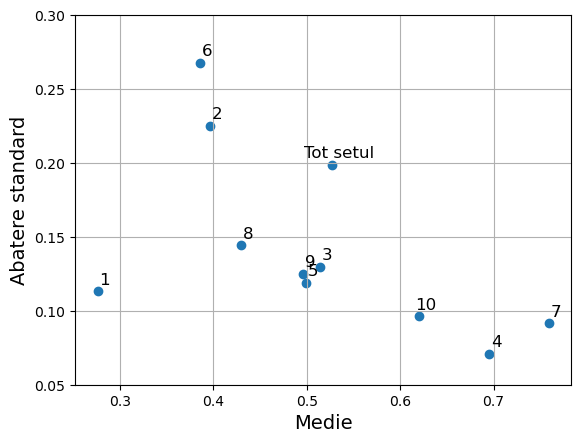

In [10]:
%matplotlib inline
plt.scatter(mean_std_df["mean"], mean_std_df["std"])
for i, txt in enumerate(mean_std_df.index):
    plt.annotate("Tot setul" if txt == "All" else txt.replace("Class", ""), xy=(mean_std_df.iloc[i]["mean"], mean_std_df.iloc[i]["std"]), textcoords="offset points", xytext=(5, 5), ha="center", fontsize=12)
plt.xlabel("Medie", fontsize=14)
plt.ylabel("Abatere standard", fontsize=14)
# plt.title(f"Mean vs Std for {subset_name}")
plt.grid(True)
plt.ylim((0.05, 0.30))
plt.savefig("./mean_std_all.pdf", bbox_inches="tight")
plt.show()

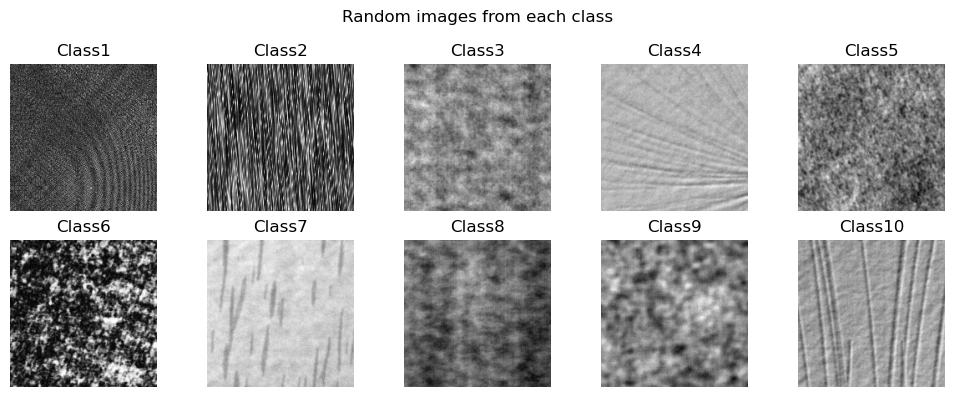

In [208]:
%matplotlib inline
all_images = []
to_image_transform = create_to_image_transform()
for class_name in class_names:
    image_names = glob.glob(os.path.join(config.DAGM_processed_dir, subset_name, class_name, "Train", "*.png"))
    random_image = to_image_transform(read_image(image_names[0])).squeeze()
    all_images.append(random_image)
plot_images(all_images, class_names, rows=2, cols=5, figsize=(10, 4), title="Random images from each class")

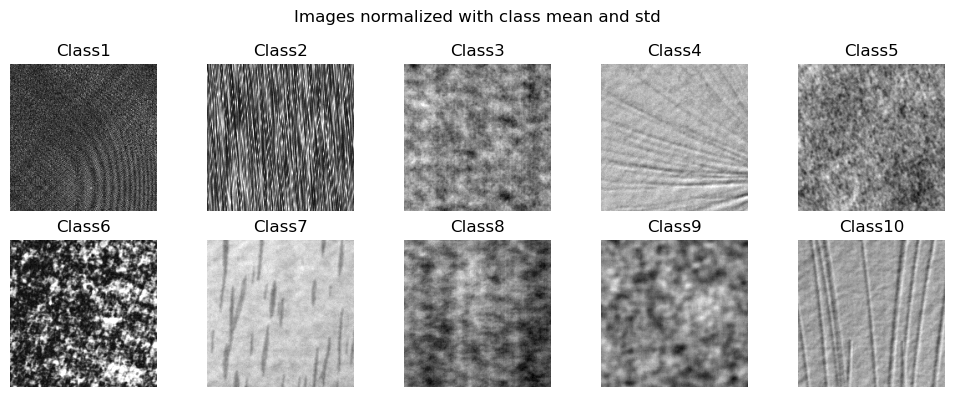

In [209]:
%matplotlib inline
normalized_per_class = [
    normalize_to_mean_std(
        image.unsqueeze(0).unsqueeze(0), mean_std_df.iloc[i]["mean"], mean_std_df.iloc[i]["std"]
    ).squeeze()
    for i, image in enumerate(all_images)
]
plot_images(
    normalized_per_class,
    class_names,
    rows=2,
    cols=5,
    figsize=(10, 4),
    title="Images normalized with class mean and std",
)

All normalized images have the same mean? True
All normalized images have the same std? True


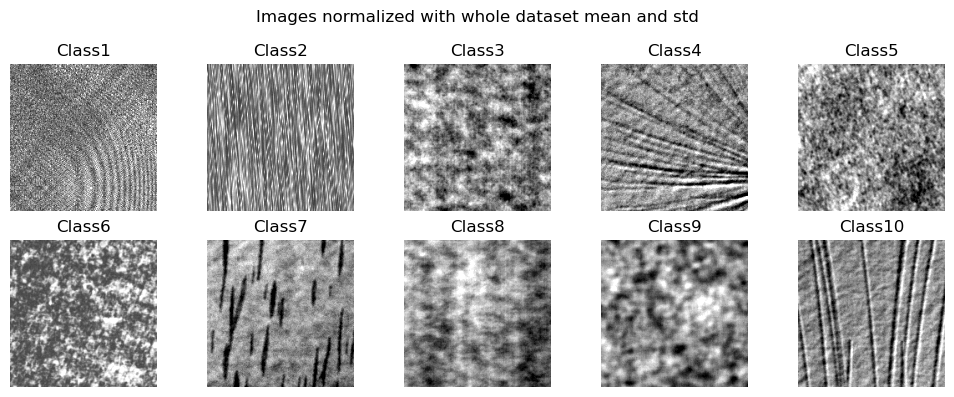

In [219]:
normalized_all = [
    normalize_to_mean_std(
        image.unsqueeze(0).unsqueeze(0), mean_std_df.loc["All"]["mean"], mean_std_df.loc["All"]["std"]
    ).squeeze()
    for image in all_images
]
normalized_all_mean = [image.mean() for image in normalized_all]
normalized_all_std = [image.std() for image in normalized_all]
print(
    f"All normalized images have the same mean? {np.allclose(normalized_all_mean, np.repeat(normalized_all_mean[0], len(normalized_all_mean)))}"
)
print(
    f"All normalized images have the same std? {np.allclose(normalized_all_std, np.repeat(normalized_all_std[0], len(normalized_all_std)))}"
)
plot_images(
    normalized_all,
    class_names,
    rows=2,
    cols=5,
    figsize=(10, 4),
    title="Images normalized with whole dataset mean and std",
)

Reversed images have the same mean values as the original images? True
Reversed images have the same std values as the original images? True
Reversed images look similar to the original images? True


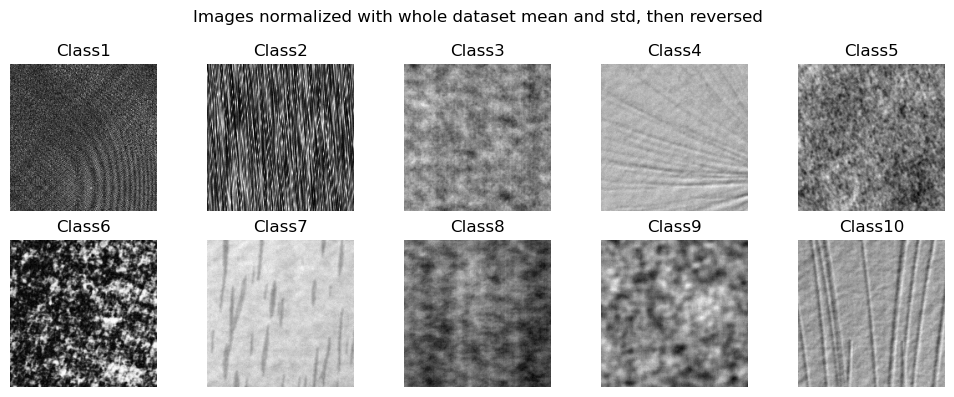

In [252]:
import torch

unit = torch.ones((1, 1, 1, 1))
reverse_norm = [
    normalize_to_mean_std(
        image.unsqueeze(0).unsqueeze(0), unit * all_images[i].mean(), unit * all_images[i].std()
    ).squeeze()
    for i, image in enumerate(normalized_all)
]
all_images_mean = [image.mean() for image in all_images]
all_images_std = [image.std() for image in all_images]
print(
    f"Reversed images have the same mean values as the original images? {np.allclose(all_images_mean, np.array([image.mean() for image in reverse_norm]))}"
)
print(
    f"Reversed images have the same std values as the original images? {np.allclose(all_images_std, np.array([image.std() for image in reverse_norm]))}"
)
print(
    f"Reversed images look similar to the original images? {np.allclose(all_images, reverse_norm, atol=3e-8, rtol=1e-5)}"
)
plot_images(
    reverse_norm,
    class_names,
    rows=2,
    cols=5,
    figsize=(10, 4),
    title="Images normalized with whole dataset mean and std, then reversed",
)

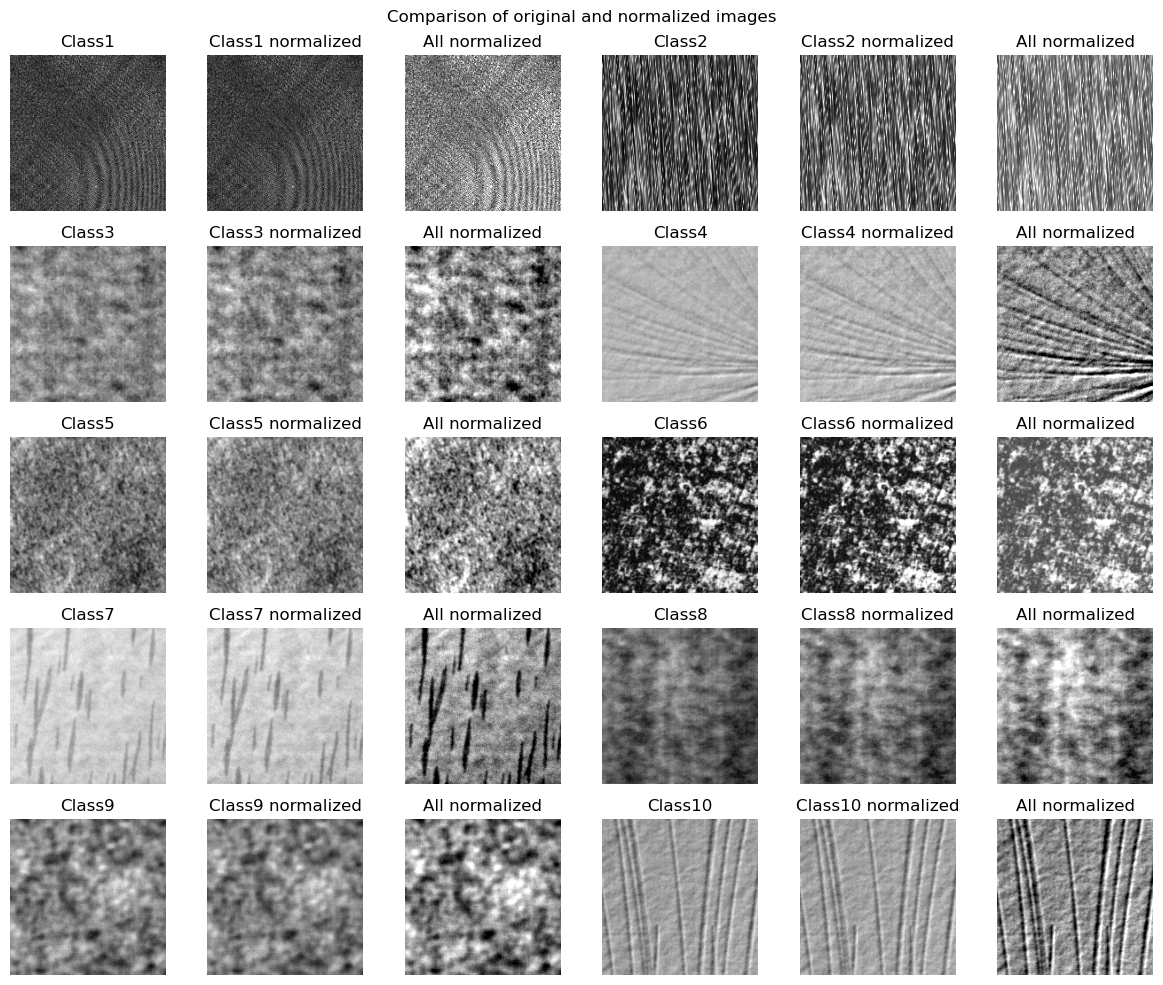

In [212]:
%matplotlib inline
def flatten(xs: list[list]) -> list:
    return [x for sublist in xs for x in sublist]


# compare_images = [image for image in all_images] + normalized_per_class + normalized_all
compare_images = flatten(zip(all_images, normalized_per_class, normalized_all))
# compare_labels = class_names + [f"Class normalized" for _ in class_names] + ["All normalized" for _ in class_names]
compare_labels = flatten(
    zip(
        class_names, [f"{class_name} normalized" for class_name in class_names], ["All normalized" for _ in class_names]
    )
)
plot_images(
    compare_images,
    compare_labels,
    rows=5,
    cols=6,
    figsize=(12, 10),
    title="Comparison of original and normalized images",
)

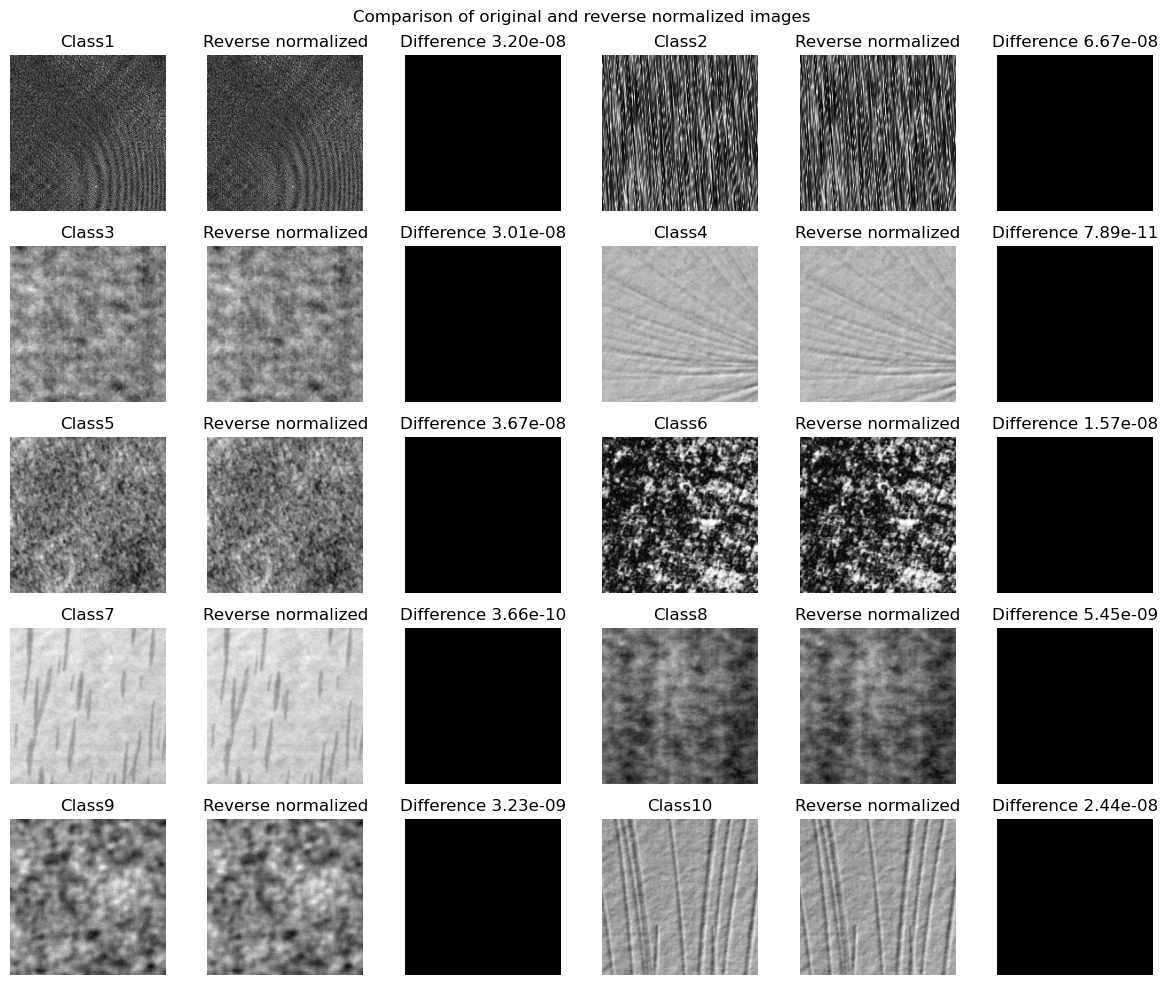

In [213]:
%matplotlib inline
def flatten(xs: list[list]) -> list:
    return [x for sublist in xs for x in sublist]


diff = [torch.abs(original - normalized) for original, normalized in zip(all_images, reverse_norm)]
# compare_images = [image for image in all_images] + normalized_per_class + normalized_all
compare_images = flatten(zip(all_images, reverse_norm, diff))
# compare_labels = class_names + [f"Class normalized" for _ in class_names] + ["All normalized" for _ in class_names]
compare_labels = flatten(
    zip(
        class_names, [f"Reverse normalized" for _ in class_names], [f"Difference {torch.mean(im).item():.2e}" for im in diff]
    )
)
plot_images(
    compare_images,
    compare_labels,
    rows=5,
    cols=6,
    figsize=(12, 10),
    title="Comparison of original and reverse normalized images",
    range="01"
)

### Better labels

Move images with defects into `DAGM_to_label` directory

In [29]:
transform = create_test_transform()
dataset = DAGMDataset(
    img_dir=config.DAGM_raw_dir,
    transform=transform,
    target_transform=transform,
    type="Defect-only",
    train=False,
)

dagm_to_label_dir = os.path.join("..", "..", "Datasets", "DAGM_to_label")
if not os.path.exists(dagm_to_label_dir):
    os.makedirs(dagm_to_label_dir)
    print(f"Created '{dagm_to_label_dir}'")
for image_class in list(range(1, 11)):
    dagm_class_dir = os.path.join(dagm_to_label_dir, f"Class{image_class}")
    if not os.path.exists(dagm_class_dir):
        os.makedirs(dagm_class_dir)
        print(f"Created '{dagm_class_dir}'")

for label_key in dataset.label_paths:
    label_path = dataset.label_paths[label_key]
    label_class = dagm_get_class(path=label_path)
    label_name = dagm_get_label_name(path=label_path)
    image_path = dagm_get_image_path(dir=config.DAGM_raw_dir, cls=label_class, image_name=label_name, train=False)
    dagm_class_dir = os.path.join(dagm_to_label_dir, f"Class{label_class}")
    new_image_path = os.path.join(dagm_class_dir, os.path.basename(image_path))
    new_label_path = os.path.join(dagm_class_dir, os.path.basename(label_path))
    shutil.copy(image_path, new_image_path)
    shutil.copy(label_path, new_label_path)

Created '..\..\Datasets\DAGM_to_label\Class1'
Created '..\..\Datasets\DAGM_to_label\Class2'
Created '..\..\Datasets\DAGM_to_label\Class3'
Created '..\..\Datasets\DAGM_to_label\Class4'
Created '..\..\Datasets\DAGM_to_label\Class5'
Created '..\..\Datasets\DAGM_to_label\Class6'
Created '..\..\Datasets\DAGM_to_label\Class7'
Created '..\..\Datasets\DAGM_to_label\Class8'
Created '..\..\Datasets\DAGM_to_label\Class9'
Created '..\..\Datasets\DAGM_to_label\Class10'


Move and rename labels exported from label studio to `DAGM_labeled` dir

In [10]:
label_studio_class = 10

dagm_labeled_dir = os.path.join("..", "..", "Datasets", "DAGM_labeled")
if not os.path.exists(dagm_labeled_dir):
    os.makedirs(dagm_labeled_dir)
    print(f"Created '{dagm_labeled_dir}'")
for image_class in list(range(1, 11)):
    dagm_class_dir = os.path.join(dagm_labeled_dir, f"Class{image_class}")
    if not os.path.exists(dagm_class_dir):
        os.makedirs(dagm_class_dir)
        print(f"Created '{dagm_class_dir}'")

dagm_label_studio_dir = os.path.join("..", "..", "Datasets", "DAGM_label_studio", f"Class{label_studio_class}")
if not os.path.exists(dagm_label_studio_dir):
    os.makedirs(dagm_label_studio_dir)
    print(f"Created '{dagm_label_studio_dir}'")

# Get annotations_paths
annotations_paths = glob.glob(os.path.join(dagm_label_studio_dir, "task-*-annotation-*-by-1-tag-Anomaly-0.png"))
sort_fn = lambda path: int(os.path.basename(path).split('-')[1])
annotations_paths = sorted(annotations_paths, key=sort_fn)

# Get label paths
dagm_to_label_dir = os.path.join("..", "..", "Datasets", "DAGM_to_label")
dagm_class_dir = os.path.join(dagm_to_label_dir, f"Class{label_studio_class}")
dagm_to_label_paths = glob.glob(os.path.join(dagm_class_dir, "*_label.PNG"))
dagm_labeled_dir = os.path.join("..", "..", "Datasets", "DAGM_labeled")

r = input(f"Will copy {len(annotations_paths)} annotations for class {label_studio_class} to '{dagm_labeled_dir}'. Press y to continue.")
if r.lower() == "y":
    for annotation_path, dagm_to_label_path in zip(annotations_paths, dagm_to_label_paths):
        label_class = dagm_get_class(path=dagm_to_label_path)
        label_name = dagm_get_label_name(path=dagm_to_label_path)
        dagm_labeled_class_dir = os.path.join(dagm_labeled_dir, f"Class{label_class}")
        new_label_path = os.path.join(dagm_labeled_class_dir, os.path.basename(dagm_to_label_path).replace("_label", "_label_better"))
        shutil.copy(annotation_path, new_label_path)


Move better labels from `DAGM_labeled` dir to `DAGM` dir

In [11]:
dagm_labeled_class = 10 # The class for which to move images

dagm_labeled_dir = os.path.join("..", "..", "Datasets", "DAGM_labeled")
dagm_label_class_dir = os.path.join(config.DAGM_raw_dir, f"Class{dagm_labeled_class}", "Test", "Label")
dagm_labeled_class_dir = os.path.join(dagm_labeled_dir, f"Class{dagm_labeled_class}")
dagm_labeled_paths = glob.glob(os.path.join(dagm_labeled_class_dir, "*_label_better.PNG"))
r = input(f"Will copy {len(dagm_labeled_paths)} labeled images for class {dagm_labeled_class} to '{dagm_label_class_dir}'. Press y to continue.")
if r.lower() == "y":
    for dagm_labeled_path in dagm_labeled_paths:
        dagm_label_path = os.path.join(dagm_label_class_dir, os.path.basename(dagm_labeled_path))
        shutil.copy(dagm_labeled_path, dagm_label_path)

Sanity checks

In [45]:
label_class = 10
dagm_label_dir = os.path.join(config.DAGM_raw_dir, f"Class{label_class}", "Test", "Label")
dagm_label_paths = glob.glob(os.path.join(dagm_label_dir, "*.PNG"))
print(f"Total number of labels in '{dagm_label_dir}': {len(dagm_label_paths)}")
label_paths = [path for path in dagm_label_paths if os.path.basename(path).endswith("_label.PNG")]
print(f"Number of original labels: {len(label_paths)}")
better_label_paths = [path for path in dagm_label_paths if os.path.basename(path).endswith("_label_better.PNG")]
print(f"Number of better labels: {len(better_label_paths)}")
assert len(label_paths) == len(better_label_paths), "Number of original labels and better labels do not match."

better_label_sizes = []
for label_path, better_label_path in zip(label_paths, better_label_paths):
    label_name, better_label_name = dagm_get_label_name(label_path), dagm_get_label_name(better_label_path)
    assert label_name == better_label_name, f"Names do not match: {label_name} & {better_label_name}"
    label = read_image(label_path)
    better_label = read_image(better_label_path)
    better_label_size = torch.sum(better_label)
    better_label_sizes.append(better_label_size)
    assert better_label_size > 0, f"Empty label found: {label_name}"

Total number of labels in 'C:\Stefan\Facultate\Licenta\Datasets\DAGM\Class10\Test\Label': 300
Number of original labels: 150
Number of better labels: 150
